## STR459: AI and robotics

#### Setting up the project

In [ ]:
# Install packages
pip install tensorflow pandas matplotlib scikit-learn seaborn

In [23]:
# Import libraries:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import (
    MobileNetV2, ResNet50V2, resnet_v2, 
    EfficientNetB1, efficientnet,
)
from tensorflow.keras.models import Model

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split

import seaborn as sns

In [ ]:
# Script to assign and move files automatically to maps called train, val and test 
def move_images_with_labels(image_dir, target_dir, label):
    """
    #Move images from a source directory to the target directory while
    #labeling them as 'Negative' (0) or 'Positive' (1).
    
    #Parameters:
    #- image_dir: The source directory containing images.
    #- target_dir: The base directory where the images will be moved.
    #- label: The label for the class (0 for Negative, 1 for Positive).
    """
    images = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]

    # Split images into train, validation, and test sets (60%, 20%, 20%)
    train_imgs, temp_imgs = train_test_split(images, test_size=0.4, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    # Helper function to move images to the correct folder
    def move_to_folder(img_list, folder_name):
        for img in img_list:
            src_path = os.path.join(image_dir, img)
            dest_path = os.path.join(target_dir, folder_name, img)
            shutil.move(src_path, dest_path)
    
    # Create the necessary subfolders if they don't exist
    os.makedirs(os.path.join(target_dir, 'train', str(label)), exist_ok=True)
    os.makedirs(os.path.join(target_dir, 'val', str(label)), exist_ok=True)
    os.makedirs(os.path.join(target_dir, 'test', str(label)), exist_ok=True)

    # Move images to the respective folders with the correct label
    move_to_folder(train_imgs, 'train/' + str(label))
    move_to_folder(val_imgs, 'val/' + str(label))
    move_to_folder(test_imgs, 'test/' + str(label))

# Define directories for Positive and Negative images
positive_dir = 'Positive'  # Replace with your actual path
negative_dir = 'Negative'  # Replace with your actual path
target_dir = 'output_data'  # Replace with your actual target directory

# Move Positive and Negative images with labels
move_images_with_labels(positive_dir, target_dir, label=1)  # Label 1 for Positive
move_images_with_labels(negative_dir, target_dir, label=0)  # Label 0 for Negative

In [6]:
# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define paths
base_dir = "output_data"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Defining hyperparameters
batch_size = 32
img_size = (227, 227)
epochs = 200

In [7]:
# Create tf.data Datasets from directory structure
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='binary',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode='binary',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='binary',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

Found 5358 files belonging to 2 classes.
Found 1786 files belonging to 2 classes.
Found 1788 files belonging to 2 classes.


#### Exploratory Data Analysis:

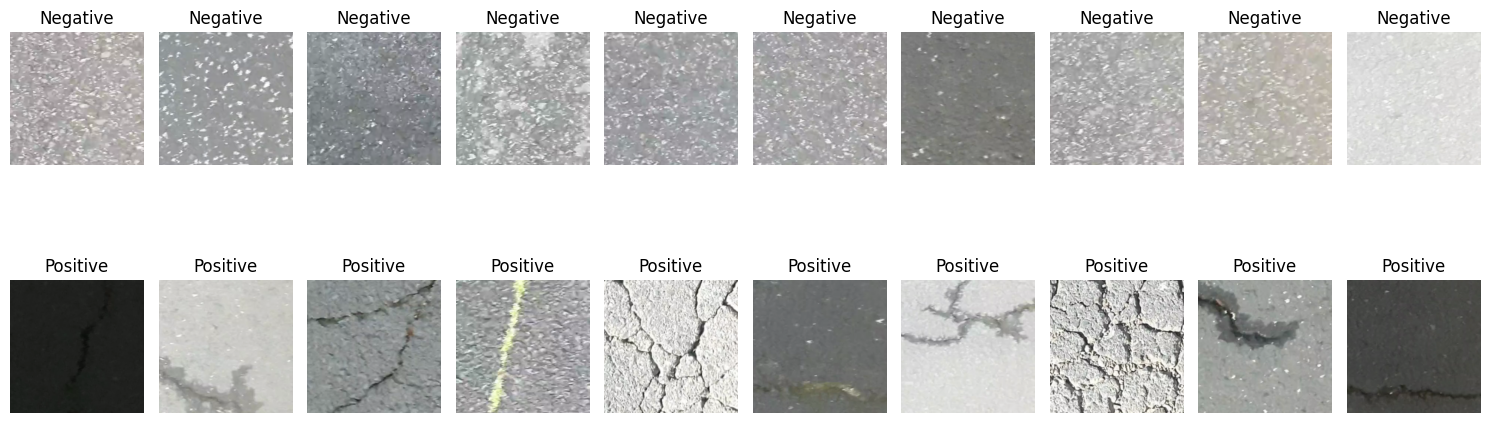

In [ ]:
## Visual Inspection:

def get_images_by_label(dataset, label, num_samples):
    """
    Retrieve `num_samples` images from the given `dataset` that match `label`.
    Returns a list of NumPy arrays.
    """
    images = []
    for img_batch, label_batch in dataset:
        for img, lbl in zip(img_batch, label_batch):
            if lbl == label:
                images.append(img.numpy().astype("uint8"))
                if len(images) >= num_samples:
                    return images
    return images

# Get 10 negative (0) and 10 positive (1) images
negative_images = get_images_by_label(val_ds, label=0, num_samples=10)
positive_images = get_images_by_label(val_ds, label=1, num_samples=10)

# Display them in a 2×10 grid
fig, axes = plt.subplots(2, 10, figsize=(15, 6))

for i, img in enumerate(negative_images):
    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    axes[0, i].set_title("Negative")

for i, img in enumerate(positive_images):
    axes[1, i].imshow(img)
    axes[1, i].axis("off")
    axes[1, i].set_title("Positive")

plt.tight_layout()
plt.show()

In [10]:
# Generate summary statistics with class distribution

def summarize(ds, name):
    """
    Summarize and print number of cracked (c), uncracked (u) images, resolution and channels
    """
    c = u = 0
    res = ch = None
    for x, y in ds:
        y = y.numpy()
        c += (y == 1).sum()
        u += (y == 0).sum()
        if res is None:
            res = x.shape[1:3]
            ch = x.shape[3] if len(x.shape) == 4 else 1
    print(f"{name:10} | Cracked: {c:4} | Uncracked: {u:4} | Res: {res[0]}x{res[1]} | Channels: {ch}")

summarize(train_ds, "Train")
summarize(val_ds, "Validation")
summarize(test_ds, "Test")

Train      | Cracked: 2679 | Uncracked: 2679 | Res: 227x227 | Channels: 3
Validation | Cracked:  893 | Uncracked:  893 | Res: 227x227 | Channels: 3
Test       | Cracked:  894 | Uncracked:  894 | Res: 227x227 | Channels: 3


In [11]:
## t-SNE Visualization of Extracted Featurest-SNE Visualization of Extracted Features
#
# We will use **MobileNetV2** as a feature extractor (without its classifier). 
# Then we will run t-SNE on these extracted features to see if there are any natural clusters.

base_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(
    inputs=base_mobilenet.input, 
    outputs=GlobalAveragePooling2D()(base_mobilenet.output)
)

def extract_features(dataset):
    """
    For each batch in `dataset`, resize images to (224, 224),
    extract features using `feature_extractor`,
    and collect labels.
    """
    all_features = []
    all_labels   = []
    for images, labels in dataset:
        # Resize images to match MobileNetV2 input
        resized = tf.image.resize(images, (224, 224))
        feats = feature_extractor.predict(resized, verbose=1)
        all_features.append(feats)
        all_labels.extend(labels.numpy())
    return np.vstack(all_features), np.array(all_labels)

# Extract features from the *training* dataset
train_features, train_labels = extract_features(train_ds)

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(train_features)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

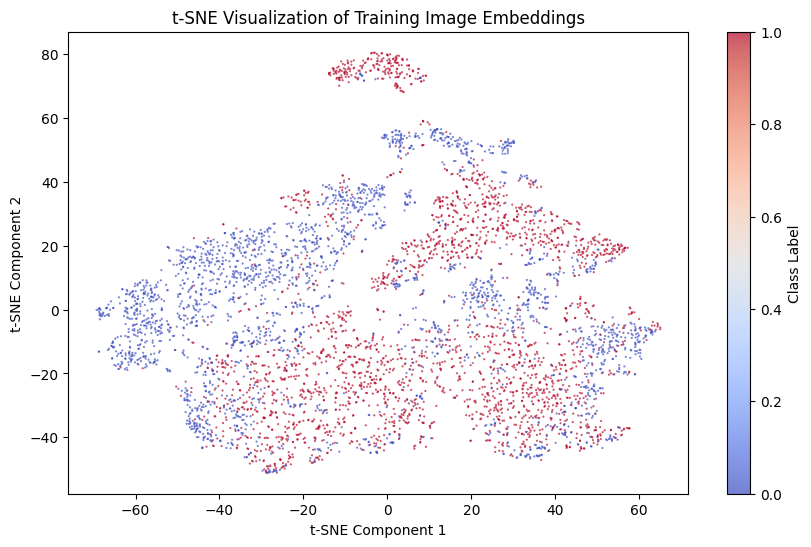

In [12]:
# Plot t-SNE visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    tsne_results[:, 0], 
    tsne_results[:, 1], 
    c=train_labels, 
    cmap="coolwarm", 
    alpha=0.7,
    s = 0.3
)
plt.colorbar(label="Class Label")
plt.title("t-SNE Visualization of Training Image Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

#### Build and Train models

In [13]:
# Data Augumentation
preprocessing = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"), # Flips pictures
    layers.RandomRotation(0.2),  # Rotates pictures rondomly (around ±72°)
    layers.RandomContrast(0.2),  # Random contrast adjustment
])

In [14]:
## ---------------------------------
## ResNet50V2
## ---------------------------------

resnet_base = ResNet50V2(include_top=False, weights='imagenet', input_shape=(227, 227, 3))
resnet_base.trainable = False 

resnet_model = keras.Sequential([
    layers.Input(shape=(227, 227, 3)),
    preprocessing,
    resnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.Dropout(0.35),
    layers.Dense(1, activation='sigmoid')
], name='ResNet50V2_model')

In [15]:
## ---------------------------------
## EfficientNetB1 Model
## ---------------------------------

effnet_base = EfficientNetB1(include_top=False, weights='imagenet', input_shape=(227, 227, 3))
effnet_base.trainable = False

effnet_model = keras.Sequential([
    layers.Input(shape=(227, 227, 3)),
    preprocessing,
    effnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.Dropout(0.35),
    layers.Dense(1, activation='sigmoid')
], name='EfficientNetB1_model')

In [16]:
## ---------------------------------
## Custom CNN
## ---------------------------------

custom_model = keras.Sequential([
    layers.Input(shape=(227, 227, 3)),
    preprocessing,

    layers.Conv2D(16, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),

    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),

    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.35),
    layers.Dense(1, activation='sigmoid')
], name='Custom_model')

In [17]:
# Preprocessing

AUTOTUNE = tf.data.AUTOTUNE

def resnet_preprocess(x, y):
    return resnet_v2.preprocess_input(x), y  # Normalize images, keep labels unchanged

# For the custom model, simple rescaling is sufficient
def simple_rescaling(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

# Apply preprocessing inside a `map()`
train_ds_resnet = train_ds.map(lambda x, y: resnet_preprocess(x, y)).cache().prefetch(AUTOTUNE)
val_ds_resnet = val_ds.map(lambda x, y: resnet_preprocess(x, y)).cache().prefetch(AUTOTUNE)
test_ds_resnet = test_ds.map(lambda x, y: resnet_preprocess(x, y)).cache().prefetch(AUTOTUNE)

train_ds_custom = train_ds.map(simple_rescaling).cache().prefetch(AUTOTUNE)
val_ds_custom   = val_ds.map(simple_rescaling).cache().prefetch(AUTOTUNE)
test_ds_custom   = test_ds.map(simple_rescaling).cache().prefetch(AUTOTUNE)

In [18]:
# Compile all models
models = [resnet_model, effnet_model, custom_model]
for m in models:
    m.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[keras.metrics.BinaryAccuracy()]
    )

# Base callbacks
callbacks_template = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

# Training function
def train_model(model, train_ds, val_ds, model_name, epochs):
    print(f"Training {model_name}...")
    callbacks = callbacks_template + [
        keras.callbacks.ModelCheckpoint(
            filepath=f"best_{model_name.lower()}_model.keras",
            monitor='val_binary_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks
    )
    return history

# Train all models
model_configs = [
    (resnet_model, train_ds_resnet, val_ds_resnet, "ResNet50V2"),
    (effnet_model, train_ds, val_ds, "EfficientNetB1"),
    (custom_model, train_ds_custom, val_ds_custom, "Custom CNN")
]

histories = {}
for model, train_ds, val_ds, name in model_configs:
    histories[name] = train_model(model, train_ds, val_ds, name, epochs)

Training ResNet50V2...
Epoch 1/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - binary_accuracy: 0.8836 - loss: 0.2799
Epoch 1: val_binary_accuracy improved from -inf to 0.98096, saving model to best_resnet50v2_model.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 71s 407ms/step - binary_accuracy: 0.8838 - loss: 0.2795 - val_binary_accuracy: 0.9810 - val_loss: 0.0604 - learning_rate: 0.0010
Epoch 2/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - binary_accuracy: 0.9449 - loss: 0.1549
Epoch 2: val_binary_accuracy improved from 0.98096 to 0.98320, saving model to best_resnet50v2_model.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 66s 391ms/step - binary_accuracy: 0.9449 - loss: 0.1549 - val_binary_accuracy: 0.9832 - val_loss: 0.0584 - learning_rate: 0.0010
Epoch 3/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - binary_accuracy: 0.9471 - loss: 0.1499
Epoch 3: val_binary_accuracy did not improve from 0.98320
168/168 ━━━━━━━━━━━━━━━━━━━━ 66s 391ms/step - binary_accuracy: 0.9471 - loss: 0.1499 - val_binary_accura

Evaluate Model Performance with Confusion Matrices and ROC Curves

Evaluating ResNet50V2...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


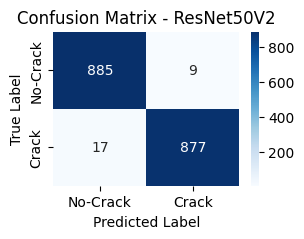

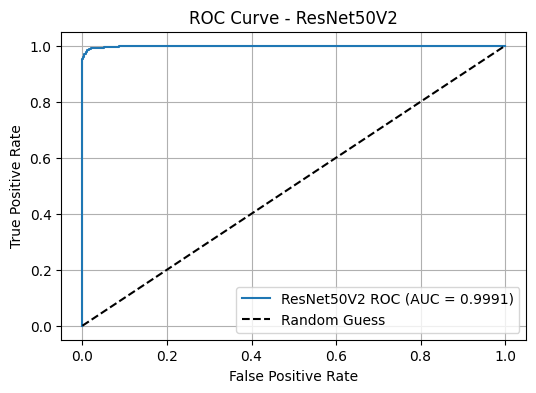

ResNet50V2 - Accuracy: 0.9855, Precision: 0.9898, Recall: 0.9810, F1-Score: 0.9854

Evaluating EfficientNetB1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302m

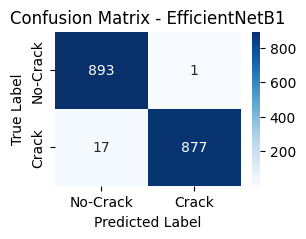

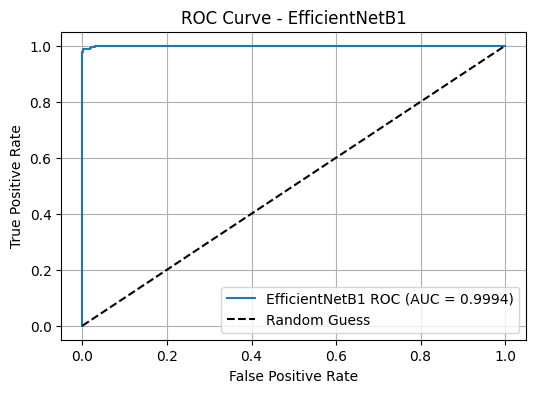

EfficientNetB1 - Accuracy: 0.9899, Precision: 0.9989, Recall: 0.9810, F1-Score: 0.9898

Evaluating Custom...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━

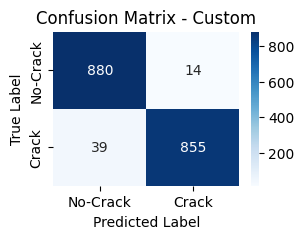

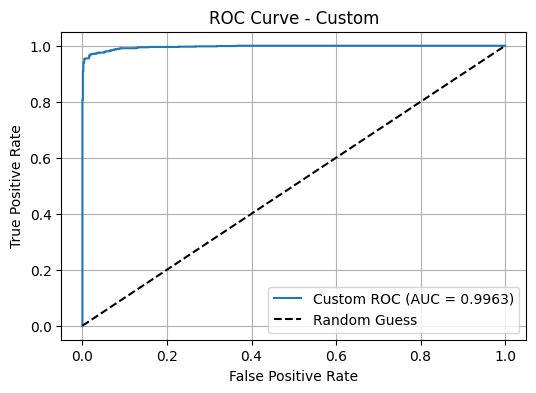

Custom - Accuracy: 0.9704, Precision: 0.9839, Recall: 0.9564, F1-Score: 0.9699



In [24]:
# Dictionary to store results for each model
model_results = {}

# List of models with associated test dataset
models_dict = {
    "ResNet50V2": (resnet_model, test_ds_resnet),
    "EfficientNetB1": (effnet_model, test_ds),
    "Custom": (custom_model, test_ds_custom)
}

for model_name, (model, test_dataset) in models_dict.items():
    print(f"Evaluating {model_name}...")
    
    # Get true labels and predictions (probabilities)
    y_true = []
    y_probs = []
    for images, labels in test_dataset:
        probs = model.predict(images).flatten()
        y_probs.extend(probs)
        y_true.extend(labels.numpy())
    
    y_true = np.array(y_true)
    y_probs = np.array(y_probs)
    
    # Convert probabilities to binary predictions (using 0.5 threshold)
    y_pred = (y_probs > 0.5).astype(int)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(3, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No-Crack', 'Crack'], 
                yticklabels=['No-Crack', 'Crack'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    auc_score = roc_auc_score(y_true, y_probs)
    
    # Plot ROC curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'{model_name} ROC (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.title(f'ROC Curve - {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    # Compute Accuracy, Precision, Recall, and F1-score
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    print(f"{model_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}\n")
    
    # Store results in dictionary
    model_results[model_name] = {
        "confusion_matrix": cm,
        "fpr": fpr,
        "tpr": tpr,
        "auc": auc_score,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }